# Level 4: Advanced Modelling #

In this level, we'll be looking at some more advanced modelling techniques with our data. In the last section we looked at using Linear Models and K-Nearest Neighbors to predict the amount of rainfall. In this section we'll explore some transformations we can make to our data as well as some machine learning technqiues that can help our predictive performance. First we start by loading our data from the csv file into a pandas dataframe.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

data = pd.read_csv("clean_weather_data.csv")
data.head()

,Month,Day,Year,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Maximum Humidity,Minimum Humidity,Precipitation,Wind Speed,Max Wind Speed,Max Gust Speed
0,1,1,2013,33,40,26,22,54,64,44,0,7,15,26
1,1,2,2013,28,33,22,11,48,57,39,0,6,15,22
2,1,3,2013,28,32,24,14,56,68,43,0,5,13,20
3,1,4,2013,34,37,30,19,56,63,48,0,8,18,28
4,1,5,2013,37,42,32,19,48,56,39,0,7,17,26


In this level we'll be predicting whether or not there will be rain on a given day. To do this we need to turn our Precipitation level data into 0's for days without rain and 1's for days with rain. This is accomplished with the following code.

In [2]:
y = np.array(data["Precipitation"] != 0,dtype = int)
data.drop('Precipitation',axis = 1, inplace = True)

So far, we haven't been using day or month data. We could potentially be missing out on some powerful features: maybe there's truth to "April showers bring May flowers". The problem is that month and day are categorical, so we can't just use the current encoding. What we have to do is add a new dimension for each possible day and month and transform the data so that every dimension is set to 0 except for the ones corrsponding to the appropriate month and day. So for example, on January 1st, both the January column and the 1st day of the month column will be set to one. This is called one of k encoding or one hot encoding. We can use sklearn to transform our data into this form with the following code. First we isolate the Day and Month columns and do one hot encoding using the OneHotEncoder class in the preprocessing module of sklearn.

In [3]:
one_hot = preprocessing.OneHotEncoder()
new_day = one_hot.fit_transform(data[["Month","Day"]]).toarray()

Here, ```fit_transform``` does all the work of figuring out what the possible categories are and assigning dimensions to them. Let's take a look to see what's happening. If we look at the first row of the resulting array we should see a 1 in the January column and a 1 on the first day of the month column.

In [4]:
new_day[0,:]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

Now we can combine the one hot encoded features with our original data and split into train and test data

In [5]:
data = data.values
data = np.hstack((new_day,data[:,2:]))

In [6]:
from sklearn import cross_validation
XTrain,XTest,yTrain,yTest = cross_validation.train_test_split(data,y,test_size = .2)

On to some machine learning techniques. A popular classification algorithm is the Support Vector Machine or SVM. Basically what the SVM does is described in the below image.

<img src=diagram_svm_maximal_margin.gif >
Source: http://www.improvedoutcomes.com/docs/WebSiteDocs/Introduction/Tutorials/Tutorial_9_Support_Vector_Machines/Tutorial_9__Introduction.htm

The goal of the SVM is to make a line which separates the two classes (red and green) as best as possible. The intuition is that the "best" way to separate the classes is the make a line which is as close to being in between both classes as possible. In the above image, panels A, B, and C aren't such good separating lines because they just barely don't touch a member of one of the classes. Panel D shows the "maximum margin" solution of the SVM, which makes a line which is equidistant from each class. The SVM generalizes to any number of dimensions, so we can use it with our data to predict whether it will rain on a particular day. For this we use sklearn's SVC class. Sklearn is designed to work fairly simply, all we have to do is call the ```fit()``` and ```predict()``` methods of the SVC class and we have a working SVM! Let's fit an SVM on our training data and test it on our test data.

In [7]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(XTrain,yTrain)
svm.score(XTest,yTest)

0.8366336633663366

That's not such a bad accuracy given that we're predicting the weather, but maybe we can do better. When the SVM is making the maximum margin line, it also allows itself to make errors and misclassify training data. We, as the data scientists, assign a cost to these misclassifications, and the cost is called a hyper parameter. But what cost do we choose? We can figure this out by using the data. What we're going to do is further break up our training data into K sections called "folds". We then iterate over many possible costs for the SVM, and for each cost we approximate the test error by iterating over all folds, leaving it out and training the SVM on the rest, and taking the average test error. This is called K-Fold Cross Validation. An example (for K = 7) is seen below.

<img src = kfolds.png>
Source: https://powerofmlexperience.wordpress.com/2015/07/15/k-fold-cross-validation-made-simple/

Say we are trying to approximate the test error for a cost of 1, using 7-fold cross validation. We would go through each line in the above image, train on the green portion and get the error on the grey portion. Afterwards we average the errors and report that. It's a bit complex, but thankfully sklearn takes care of almost everything for us with its ```grid_search``` module. We can use it (and plot the errors for different costs) as follows: first we define the parameters that we want to sweep through (in this case cost) and then we get all of the errors.

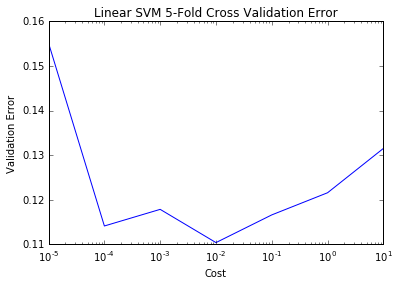

In [8]:
from sklearn import grid_search
import matplotlib.pyplot as plt
%matplotlib inline
parameters = {"kernel":["linear"],'C':[10**i for i in range(-5,2)]}
#use 5-fold cross validation
search = grid_search.GridSearchCV(SVC(),param_grid = parameters,refit=True,
                                  cv = 5)
search.fit(XTrain,yTrain)
#plot the validation error
errs = [1- score[1] for score in search.grid_scores_]
cs = parameters["C"]
plt.plot(cs,errs)
plt.semilogx()
plt.xlabel("Cost")
plt.ylabel("Validation Error")
plt.title("Linear SVM 5-Fold Cross Validation Error")

We can check what the best parameters are like this.

In [9]:
search.best_params_

{'C': 0.01, 'kernel': 'linear'}

The cool thing about sklearn is that the ```GridSearchCV``` class keeps the best SVM that it found, and then we can use it simply by using ```predict()``` and ```score()``` like before.

In [10]:
search.score(XTest,yTest)

0.8910891089108911

That's even better accuracy, but what if a straight line isn't a good way to divide the two classes? For instance, what if one class totally surrounds the other, or the line is wiggly instead of straight? We can add this to the SVM by using kernels. Basically what a kernel does is it maps our data to a higher dimension, and then the SVm can work normally and try to make a straight line which separates the data. When the data is mapped back to our dimension, the line becomes curved. Take a look at the video below to see an illustrative example.

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("3liCbRZPrZA")

For this tutorial we'll be using the Radial Basis Function or RBF kernel. It's a little bit different than the kernel above because it maps to infinite dimensions, but don't worry about that for now. When training an RBF kernel SVM, there are two hyper parameters: one is the cost, which we've dealt with before, and the other is called "gamma" and controls how wiggly the line can be. But this isn't a problem, we can just use K-Fold Cross Validation as last time, and consider pairs of costs and gammas. The code to do this is almost exactly the same as before, we just add another parameter to sweep over.

([<matplotlib.axis.YTick at 0x7fb8f26627f0>,
 <a list of 8 Text yticklabel objects>)

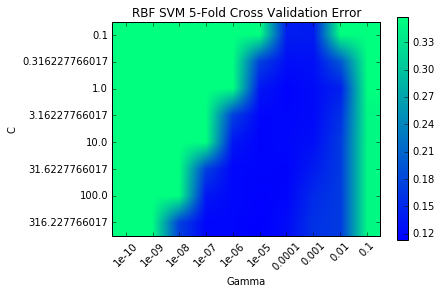

In [11]:
params = {"kernel":["rbf"], "C":[10**i for i in np.arange(-1,3,.5)],
              "gamma":[10**i for i in np.arange(-10,0,1)]}
              
search = grid_search.GridSearchCV(SVC(),param_grid = params, refit = True,
                                  cv = 5)
search.fit(XTrain,yTrain)
#plot errors
errs = [1 - score[1] for score in search.grid_scores_]

errs = np.array(errs).reshape(len(params["C"]), len(params["gamma"]))
plt.imshow(errs,cmap="winter")
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title("RBF SVM 5-Fold Cross Validation Error")
plt.colorbar()
plt.xticks(np.arange(len(params["gamma"])), params["gamma"], rotation=45)
plt.yticks(np.arange(len(params["C"])),params["C"])

Again we can check what the best parameters were, and see how our performance on the test set is

In [12]:
print(search.best_params_)
print(search.score(XTest,yTest))

{'kernel': 'rbf', 'C': 316.22776601683796, 'gamma': 1.0000000000000001e-05}
0.886138613861


In this case we get similar performance with the normal (linear) SVM and the RBF SVM, but that won't always be the case. Now you can go explore other kernels and try them out!